## CMS Exclusions Dataset Exploratory Data Analysis

In [133]:
# Import necessary libraries such as numpy and pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [134]:
# This function will provide basic insights into any data
def quick_summary(df):
    print("=== Missing Values ===")
    print(df.isnull().sum())
    print("\n=== Basic Info ===")
    print(df.info())
    print("\n=== Sample Rows ===")
    print(df.head())

### OIG Exclusions Data

In [135]:
# Load the OIG exclusions file into a pandas dataframe
exclusions_file = 'cms_data/leie.csv'
exclusions = pd.read_csv(exclusions_file)
exclusions = exclusions[exclusions.NPI > 0].set_index('NPI')

/tmp/ipykernel_98/1029917934.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exclusions = pd.read_csv(exclusions_file)


In [136]:
quick_summary(exclusions)

=== Missing Values ===
LASTNAME       524
FIRSTNAME      525
MIDNAME       2475
BUSNAME       7773
GENERAL          0
SPECIALTY      117
UPIN          6897
DOB            524
ADDRESS          0
CITY             0
STATE            0
ZIP              0
EXCLTYPE         0
EXCLDATE         0
REINDATE         0
WAIVERDATE       0
WVRSTATE      8293
dtype: int64

=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 8297 entries, 1972902351 to 1831242650
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LASTNAME    7773 non-null   object 
 1   FIRSTNAME   7772 non-null   object 
 2   MIDNAME     5822 non-null   object 
 3   BUSNAME     524 non-null    object 
 4   GENERAL     8297 non-null   object 
 5   SPECIALTY   8180 non-null   object 
 6   UPIN        1400 non-null   object 
 7   DOB         7773 non-null   float64
 8   ADDRESS     8297 non-null   object 
 9   CITY        8297 non-null   object 
 10  STATE  

In [137]:
# Drops unimportant columns or columns with mostly missing values
exclusions = exclusions.drop(
    columns=['UPIN', 'MIDNAME', 'WVRSTATE', 'BUSNAME', 'REINDATE', 'WAIVERDATE'],
    errors='ignore'  
)

exclusions.head()

,LASTNAME,FIRSTNAME,GENERAL,SPECIALTY,DOB,ADDRESS,CITY,STATE,ZIP,EXCLTYPE,EXCLDATE
NPI,,,,,,,,,,,
1972902351,NaN,NaN,OTHER BUSINESS,PHARMACY,NaN,"C/O 609 W 191ST STREET, APT D",NEW YORK,NY,10040,1128b8,20220320
1922348218,NaN,NaN,OTHER BUSINESS,PHARMACY,NaN,69 E 184TH ST,BRONX,NY,10468,1128a1,20180419
1942476080,NaN,NaN,DME COMPANY,DME - GENERAL,NaN,"6310 108TH STREET, APT 6J",FOREST HILLS,NY,11375,1128b8,20170518
1275600959,NaN,NaN,OTHER BUSINESS,HOME HEALTH AGENCY,NaN,"1229 HURON RD E, FLR 6TH",CLEVELAND,OH,44115,1128a1,20130320
1891731758,NaN,NaN,OTHER BUSINESS,PHARMACY,NaN,"C/O P O BOX 329014, #69709-05",BROOKLYN,NY,11232,1128b8,20170518


In [138]:
exclusions = exclusions.dropna(subset=['SPECIALTY'])
exclusions = exclusions.dropna(subset=['DOB'])
print(exclusions.shape)

(7723, 11)


In [139]:
date_cols = ['DOB', 'EXCLDATE']
for col in date_cols:
    exclusions[col] = exclusions[col].astype(str).str.replace(r'\.0$', '', regex=True)
    exclusions[col] = exclusions[col].replace(['nan', 'NaN', '', '00000000'], np.nan)
    exclusions[col] = pd.to_datetime(exclusions[col], format='%Y%m%d', errors='coerce')

exclusions.head()

,LASTNAME,FIRSTNAME,GENERAL,SPECIALTY,DOB,ADDRESS,CITY,STATE,ZIP,EXCLTYPE,EXCLDATE
NPI,,,,,,,,,,,
1760461826,ABAD-SANTOS,CRISELDA,"PHYSICIAN (MD, DO)",PSYCHIATRY,1963-12-20,8506 N ADIR DR,WEST HILLS,CA,91304,1128b4,2025-01-20
1477537496,ABADI,JAMSHEED,"PHYSICIAN (MD, DO)",INTERNAL MEDICINE,1939-01-10,89 WEEKS ROAD,E WILLISTON PARK,NY,11596,1128b4,2014-05-20
1124292966,ABARIENTOS,CRISPIN,"PHYSICIAN (MD, DO)",RHEUMATOLOGY,1974-09-19,"P O BOX 879, #26401-014",AYER,MA,1432,1128a1,2020-06-18
1376108431,ABBAS,SHAFI,BUS OWNER/EXEC,DME - PROSTHETICS,1967-06-06,P O BOX 26020,BEAUMONT,TX,26020,1128a1,2025-10-20
1194807255,ABBASSI,JADAN,"PHYSICIAN (MD, DO)",GENERAL PRACTICE,1944-09-19,115 NELLIS DRIVE,WAYNE,NJ,7470,1128b4,2018-06-20


In [140]:
exclusions['age_at_exclusion'] = (
    (exclusions['EXCLDATE'] - exclusions['DOB']).dt.days / 365.25
)
exclusions['year_excl'] = exclusions['EXCLDATE'].dt.year

In [141]:
excltype_map = {
    '1128a1': 'Conviction – Medicare Fraud',
    '1128a2': 'Patient Abuse/Neglect',
    '1128a3': 'Felony – Drugs',
    '1128a4': 'Felony – Healthcare Fraud',
    '1128b1': 'Misdemeanor – Fraud',
    '1128b2': 'Default on Student Loan',
    '1128b3': 'License Revocation',
    '1128b4': 'Unlawful Claims',
    '1128b5': 'Kickbacks/Bribery',
    '1128b6': 'False Claims',
    '1128b7': 'Obstruction of Audit',
    '1128b8': 'Controlled Substances Violation',
    '1128b9': 'Insurance Fraud',
    '1128b10': 'Unlawful Billing',
    '1128b11': 'Quality of Care Violation',
    '1128b12': 'Civil Monetary Penalty',
    '1128b13': 'False Statement',
    '1128b14': 'Suspension/Exclusion',
    '1128b15': 'License Suspension',
    '1128b16': 'Federal Program Violation',
}


exclusions['EXCLTYPE'] = exclusions['EXCLTYPE'].replace(excltype_map)

exclusions['EXCLTYPE'] = exclusions['EXCLTYPE'].fillna('Other')

print(exclusions['EXCLTYPE'].value_counts())

EXCLTYPE
Conviction – Medicare Fraud    2921
Unlawful Claims                2388
Felony – Healthcare Fraud       982
Felony – Drugs                  642
Patient Abuse/Neglect           370
Suspension/Exclusion            197
Obstruction of Audit             84
Kickbacks/Bribery                51
Misdemeanor – Fraud              41
License Revocation               20
False Claims                      7
Default on Student Loan           7
1128Aa                            4
BRCH SA                           4
BRCH CIA                          3
Federal Program Violation         1
1156                              1
Name: count, dtype: int64


In [142]:
quick_summary(exclusions)

=== Missing Values ===
LASTNAME            0
FIRSTNAME           1
GENERAL             0
SPECIALTY           0
DOB                 0
ADDRESS             0
CITY                0
STATE               0
ZIP                 0
EXCLTYPE            0
EXCLDATE            0
age_at_exclusion    0
year_excl           0
dtype: int64

=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 7723 entries, 1760461826 to 1831242650
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   LASTNAME          7723 non-null   object        
 1   FIRSTNAME         7722 non-null   object        
 2   GENERAL           7723 non-null   object        
 3   SPECIALTY         7723 non-null   object        
 4   DOB               7723 non-null   datetime64[ns]
 5   ADDRESS           7723 non-null   object        
 6   CITY              7723 non-null   object        
 7   STATE             7723 non-null   object        
 

In [143]:
exclusions['SPECIALTY'].value_counts().head(15)

SPECIALTY
NURSE/NURSES AIDE       826
GENERAL PRACTICE        753
FAMILY PRACTICE         591
INTERNAL MEDICINE       546
CHIROPRACTIC            422
COUNSELOR               397
DENTIST                 334
PHARMACIST              324
PSYCHIATRY              243
NURSE PRACTITIONER (    188
PAIN MANAGEMENT         179
SOCIAL WORKER           172
PHYSICIAN ASSISTANT     165
THERAPIST               160
PSYCHOLOGY              151
Name: count, dtype: int64

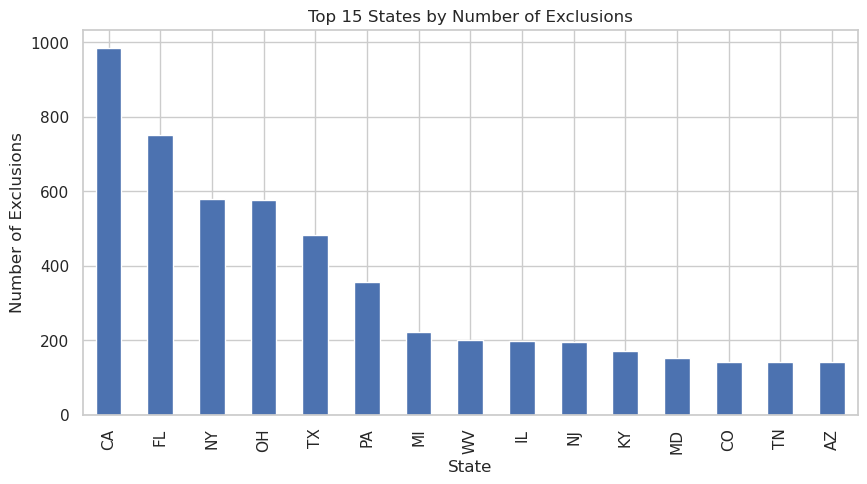

In [144]:
plt.figure(figsize=(10,5))
exclusions['STATE'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 States by Number of Exclusions')
plt.xlabel('State')
plt.ylabel('Number of Exclusions')
plt.show()

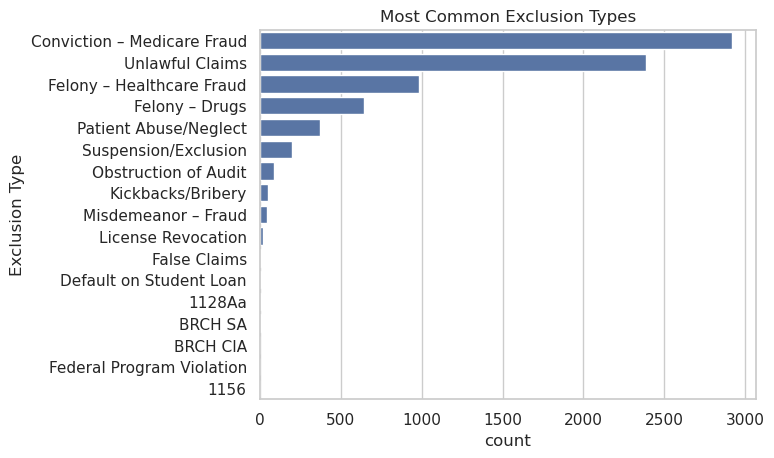

In [145]:
sns.countplot(y='EXCLTYPE', data=exclusions, order=exclusions['EXCLTYPE'].value_counts().index)
plt.ylabel("Exclusion Type")
plt.title('Most Common Exclusion Types')
plt.show()

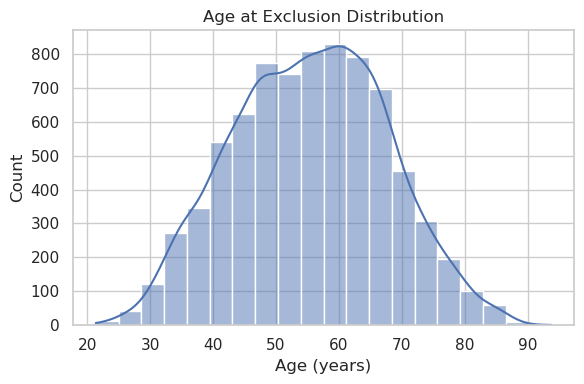

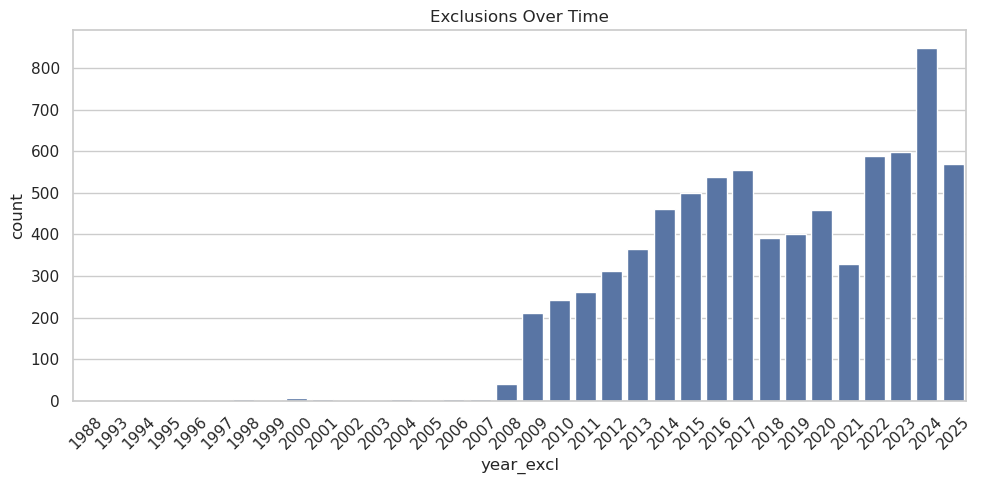

In [146]:
sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.histplot(exclusions['age_at_exclusion'].dropna(), kde=True, bins=20)
plt.title("Age at Exclusion Distribution")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(
    data=exclusions,
    x='year_excl',
    order=sorted(exclusions['year_excl'].dropna().unique())
)
plt.title("Exclusions Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_98/3599476972.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states, x='STATE', y='COUNT', palette='viridis')


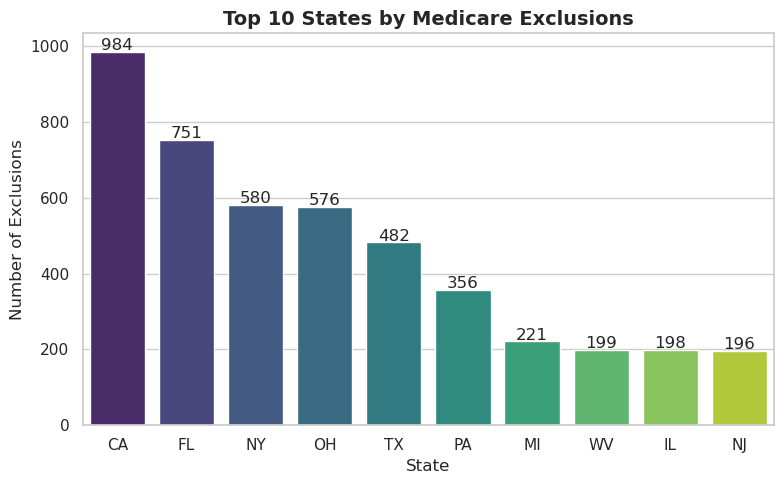

In [147]:
top_states = (
    exclusions['STATE']
    .value_counts()
    .nlargest(10)
    .reset_index()
)

top_states.columns = ['STATE', 'COUNT']


plt.figure(figsize=(8, 5))
sns.barplot(data=top_states, x='STATE', y='COUNT', palette='viridis')

plt.title("Top 10 States by Medicare Exclusions", fontsize=14, weight='bold')
plt.xlabel("State")
plt.ylabel("Number of Exclusions")

for i, row in top_states.iterrows():
    plt.text(i, row['COUNT'] + 5, int(row['COUNT']), ha='center')

plt.tight_layout()
plt.show()

### CMS Medicare Provider Data

In [148]:
files = os.listdir('cms_data')
files

['MUP_PHY_R25_P07_V10_D19_Prov.csv',
 'MUP_PHY_R25_P07_V10_D22_Prov.csv',
 '.ipynb_checkpoints',
 'MUP_PHY_R25_P07_V10_D21_Prov.csv',
 'leie.csv',
 'y2022_prep.csv',
 'y2019_prep.csv',
 'MUP_PHY_R25_P05_V20_D23_Prov.csv',
 'MUP_PHY_R25_P07_V10_D20_Prov.csv',
 'y2023_prep.csv']

In [149]:
fil = files[6]
data = pd.read_csv('cms_data/'+fil)

In [150]:
data = data.rename(columns={'Rndrng_NPI': 'NPI'})
data = data[data['NPI'] > 0].set_index('NPI')
data= data.drop('Unnamed: 0', axis=1)

In [151]:
data.head()

,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_State_FIPS,Rndrng_Prvdr_Zip5,Rndrng_Prvdr_RUCA,Rndrng_Prvdr_RUCA_Desc,Rndrng_Prvdr_Cntry,Rndrng_Prvdr_Type,Rndrng_Prvdr_Mdcr_Prtcptg_Ind,Tot_HCPCS_Cds,Tot_Benes,Tot_Srvcs,Tot_Sbmtd_Chrg,Tot_Mdcr_Alowd_Amt,Tot_Mdcr_Pymt_Amt,Tot_Mdcr_Stdzd_Amt,Drug_Sprsn_Ind,Drug_Tot_HCPCS_Cds,Drug_Tot_Benes,Drug_Tot_Srvcs,Drug_Sbmtd_Chrg,Drug_Mdcr_Alowd_Amt,Drug_Mdcr_Pymt_Amt,Drug_Mdcr_Stdzd_Amt,Med_Sprsn_Ind,Med_Tot_HCPCS_Cds,Med_Tot_Benes,Med_Tot_Srvcs,Med_Sbmtd_Chrg,Med_Mdcr_Alowd_Amt,Med_Mdcr_Pymt_Amt,Med_Mdcr_Stdzd_Amt,Bene_Avg_Age,Bene_Age_LT_65_Cnt,Bene_Age_65_74_Cnt,Bene_Age_75_84_Cnt,Bene_Age_GT_84_Cnt,Bene_Feml_Cnt,Bene_Male_Cnt,Bene_Race_Wht_Cnt,Bene_Race_Black_Cnt,Bene_Race_API_Cnt,Bene_Race_Hspnc_Cnt,Bene_Race_NatInd_Cnt,Bene_Race_Othr_Cnt,Bene_Dual_Cnt,Bene_Ndual_Cnt,Bene_CC_BH_ADHD_OthCD_V1_Pct,Bene_CC_BH_Alcohol_Drug_V1_Pct,Bene_CC_BH_Tobacco_V1_Pct,Bene_CC_BH_Alz_NonAlzdem_V2_Pct,Bene_CC_BH_Anxiety_V1_Pct,Bene_CC_BH_Bipolar_V1_Pct,Bene_CC_BH_Mood_V2_Pct,Bene_CC_BH_Depress_V1_Pct,Bene_CC_BH_PD_V1_Pct,Bene_CC_BH_PTSD_V1_Pct,Bene_CC_BH_Schizo_OthPsy_V1_Pct,Bene_CC_PH_Asthma_V2_Pct,Bene_CC_PH_Afib_V2_Pct,Bene_CC_PH_Cancer6_V2_Pct,Bene_CC_PH_CKD_V2_Pct,Bene_CC_PH_COPD_V2_Pct,Bene_CC_PH_Diabetes_V2_Pct,Bene_CC_PH_HF_NonIHD_V2_Pct,Bene_CC_PH_Hyperlipidemia_V2_Pct,Bene_CC_PH_Hypertension_V2_Pct,Bene_CC_PH_IschemicHeart_V2_Pct,Bene_CC_PH_Osteoporosis_V2_Pct,Bene_CC_PH_Parkinson_V2_Pct,Bene_CC_PH_Arthritis_V2_Pct,Bene_CC_PH_Stroke_TIA_V2_Pct,Bene_Avg_Risk_Scre,LASTNAME,FIRSTNAME,MIDNAME,BUSNAME,GENERAL,SPECIALTY,UPIN,DOB,ADDRESS,CITY,STATE,ZIP,EXCLTYPE,EXCLDATE,REINDATE,WAIVERDATE,WVRSTATE,rat_Drug_Mdcr_Alowd_Amt_Drug_Mdcr_Pymt_Amt,rat_Tot_Mdcr_Alowd_Amt_Med_Sbmtd_Chrg,rat_Drug_Tot_Benes_Tot_Benes,excluded,rand
NPI,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1003000134,CIBULL,THOMAS,L,M.D.,I,2650 RIDGE AVE,EVANSTON HOSPITAL,EVANSTON,IL,17,60201.0,1.0,Metropolitan area core: primary flow within an...,US,Pathology,Y,20,3614,7835.0,1213264.0,298905.09,228078.56,218268.63,NaN,0.0,0.0,0.0,0.0,0.00,0.00,0.00,NaN,20.0,3614.0,7835.0,1213264.0,298905.09,228078.56,218268.63,76,97.0,1623.0,1333.0,561.0,1767.0,1847.0,3312.0,41.0,62.0,43.0,0.0,156.0,195.0,3419.0,0.0,2.0,3.0,4.0,13.0,2.0,16.0,14.0,1.0,0.0,1.0,6.0,16.0,18.0,15.0,10.0,21.0,11.0,72.0,64.0,20.0,15.0,3.0,42.0,6.0,1.1246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UNK,NaN,NaN,NaN,NaN,NaN,0.246364,0.000000,0,0.994100
1003005315,SMITH,ADAM,B,MD,I,4977 SKYVIEW CT,NaN,TRAVERSE CITY,MI,26,49684.0,4.0,Micropolitan area core: primary flow within an...,US,Plastic and Reconstructive Surgery,Y,51,71,533.0,250569.0,86114.40,67712.67,70489.71,*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,NaN,29.0,20.0,NaN,44.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,57.0,NaN,NaN,NaN,NaN,35.0,NaN,32.0,30.0,NaN,NaN,NaN,NaN,24.0,17.0,25.0,17.0,45.0,NaN,63.0,75.0,23.0,NaN,NaN,48.0,NaN,1.6177,SMITH,ADAM,BRYANT,NaN,"PHYSICIAN (MD, DO)",PLASTIC SURGERY,NaN,19800519.0,2136 FORD PKWY 5103,SAINT PAUL,MN,55116.0,1128a1,20221220.0,0.0,0.0,NaN,NaN,NaN,NaN,1,0.253627
1003009861,BANNA,MOUSTAFA,NaN,MD,I,5859 W. TALAVI BLVD,SUITE 100,GLENDALE,AZ,4,85306.0,1.0,Metropolitan area core: primary flow within an...,US,Cardiology,Y,68,876,3581.0,788610.0,361645.81,280928.83,286768.20,NaN,1.0,98.0,392.0,63504.0,21905.24,17472.35,18074.19,NaN,67.0,876.0,3189.0,725106.0,339740.57,263456.48,268694.01,73,91.0,400.0,294.0,91.0,410.0,466.0,709.0,35.0,20.0,80.0,11.0,21.0,164.0,712.0,NaN,13.0,21.0,12.0,29.0,5.0,31.0,28.0,NaN,3.0,3.0,15.0,38.0,19.0,42.0,34.0,40.0,37.0,75.0,75.0,61.0,13.0,2.0,50.0,22.0,2.1074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UNK,NaN,NaN,NaN,NaN,1.253709,0.498749,0.111872,0,0.994092
1003010570,CHOW,LING,S,M.D.,I,900 E BROADWAY AVE,NaN,BISMARCK,ND,38,58501.

In [152]:
quick_summary(data)

=== Missing Values ===
Rndrng_Prvdr_Last_Org_Name                       0
Rndrng_Prvdr_First_Name                        649
Rndrng_Prvdr_MI                               4210
Rndrng_Prvdr_Crdntls                          1302
Rndrng_Prvdr_Ent_Cd                              0
                                              ... 
rat_Drug_Mdcr_Alowd_Amt_Drug_Mdcr_Pymt_Amt    9475
rat_Tot_Mdcr_Alowd_Amt_Med_Sbmtd_Chrg         1410
rat_Drug_Tot_Benes_Tot_Benes                  1410
excluded                                         0
rand                                             0
Length: 102, dtype: int64

=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 12470 entries, 1003000134 to 1992999759
Columns: 102 entries, Rndrng_Prvdr_Last_Org_Name to rand
dtypes: float64(70), int64(5), object(27)
memory usage: 9.8+ MB
None

=== Sample Rows ===
           Rndrng_Prvdr_Last_Org_Name Rndrng_Prvdr_First_Name Rndrng_Prvdr_MI  \
NPI                                                      

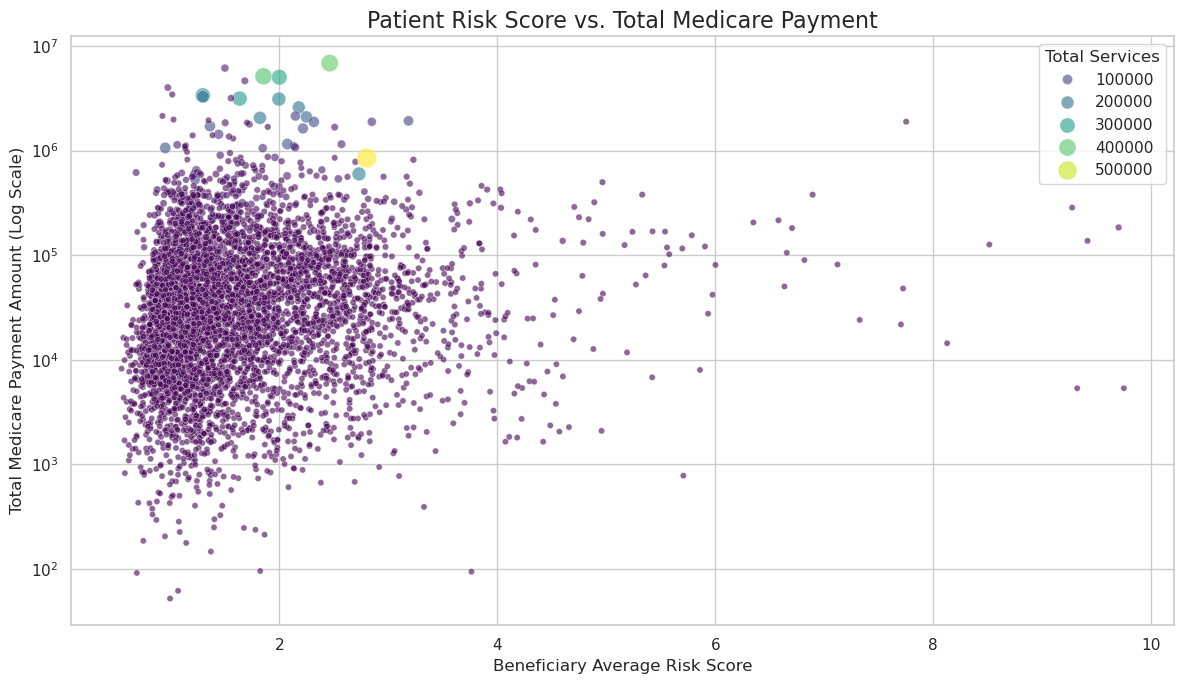

In [153]:
plt.figure(figsize=(12, 7))

sample_df = data.sample(n=5000, random_state=42)

ax = sns.scatterplot(
    data=sample_df,
    x='Bene_Avg_Risk_Scre',
    y='Tot_Mdcr_Pymt_Amt',
    hue='Tot_Srvcs',
    size='Tot_Srvcs', 
    sizes=(20, 200),
    palette='viridis',
    alpha=0.6
)

ax.set_yscale('log')
plt.title('Patient Risk Score vs. Total Medicare Payment', fontsize=16)
plt.xlabel('Beneficiary Average Risk Score', fontsize=12)
plt.ylabel('Total Medicare Payment Amount (Log Scale)', fontsize=12)
plt.legend(title='Total Services')
plt.tight_layout()
plt.style.use("seaborn-v0_8-dark-palette")
plt.show()

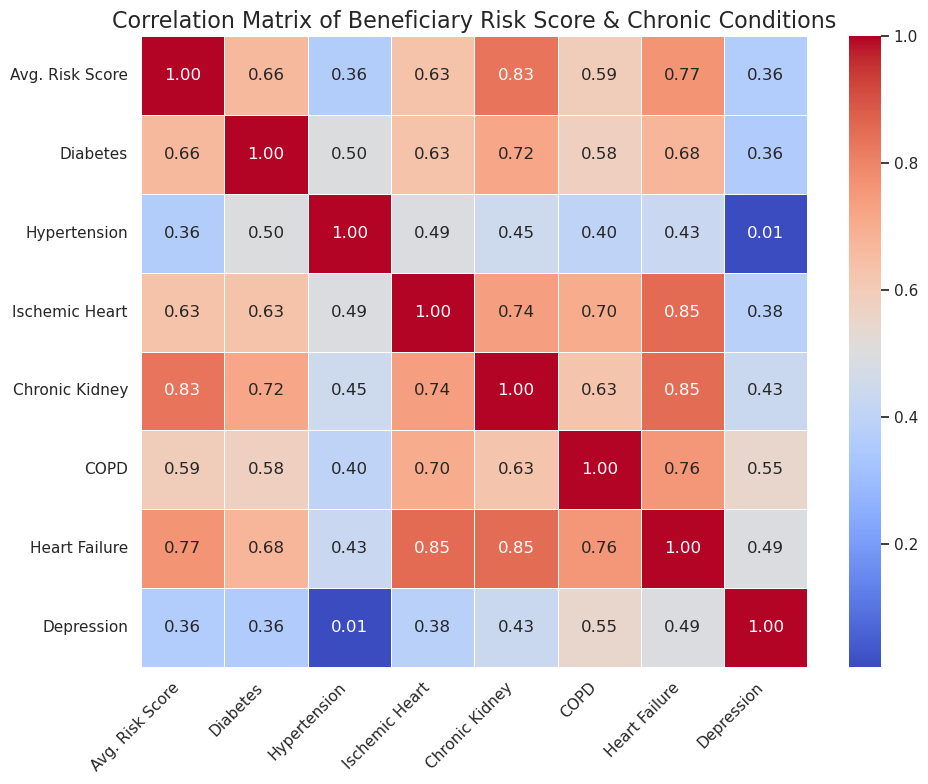

In [154]:


cc_cols_of_interest = [
    'Bene_Avg_Risk_Scre',
    'Bene_CC_PH_Diabetes_V2_Pct',
    'Bene_CC_PH_Hypertension_V2_Pct',
    'Bene_CC_PH_IschemicHeart_V2_Pct',
    'Bene_CC_PH_CKD_V2_Pct',
    'Bene_CC_PH_COPD_V2_Pct',
    'Bene_CC_PH_HF_NonIHD_V2_Pct',
    'Bene_CC_BH_Depress_V1_Pct'
]


corr_matrix = data[cc_cols_of_interest].corr()


label_map = {
    'Bene_Avg_Risk_Scre': 'Avg. Risk Score',
    'Bene_CC_PH_Diabetes_V2_Pct': 'Diabetes',
    'Bene_CC_PH_Hypertension_V2_Pct': 'Hypertension',
    'Bene_CC_PH_IschemicHeart_V2_Pct': 'Ischemic Heart',
    'Bene_CC_PH_CKD_V2_Pct': 'Chronic Kidney',
    'Bene_CC_PH_COPD_V2_Pct': 'COPD',
    'Bene_CC_PH_HF_NonIHD_V2_Pct': 'Heart Failure',
    'Bene_CC_BH_Depress_V1_Pct': 'Depression'
}


corr_matrix_renamed = corr_matrix.rename(columns=label_map, index=label_map)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix_renamed, 
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)

plt.title('Correlation Matrix of Beneficiary Risk Score & Chronic Conditions', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.style.use("seaborn-v0_8-dark-palette")
plt.show()

# Linear Regression/Modeling

In [155]:
df = pd.merge(data, exclusions, on='NPI',how='left')

In [156]:
df['excluded'].unique()

array([0, 1])

In [157]:
len(df)

12496

In [158]:
df.columns

Index(['Rndrng_Prvdr_Last_Org_Name', 'Rndrng_Prvdr_First_Name',
       'Rndrng_Prvdr_MI', 'Rndrng_Prvdr_Crdntls', 'Rndrng_Prvdr_Ent_Cd',
       'Rndrng_Prvdr_St1', 'Rndrng_Prvdr_St2', 'Rndrng_Prvdr_City',
       'Rndrng_Prvdr_State_Abrvtn', 'Rndrng_Prvdr_State_FIPS',
       ...
       'SPECIALTY_y', 'DOB_y', 'ADDRESS_y', 'CITY_y', 'STATE_y', 'ZIP_y',
       'EXCLTYPE_y', 'EXCLDATE_y', 'age_at_exclusion', 'year_excl'],
      dtype='object', length=115)

In [159]:
df = df.copy()

# 1 if excluded (has an exclusion date), 0 otherwise
df['is_excluded'] = df['EXCLDATE_y'].notna().astype(int)

# keep rows where provider type is known
df = df[df['Rndrng_Prvdr_Type'].notna()]
df.head()

,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_State_FIPS,Rndrng_Prvdr_Zip5,Rndrng_Prvdr_RUCA,Rndrng_Prvdr_RUCA_Desc,Rndrng_Prvdr_Cntry,Rndrng_Prvdr_Type,Rndrng_Prvdr_Mdcr_Prtcptg_Ind,Tot_HCPCS_Cds,Tot_Benes,Tot_Srvcs,Tot_Sbmtd_Chrg,Tot_Mdcr_Alowd_Amt,Tot_Mdcr_Pymt_Amt,Tot_Mdcr_Stdzd_Amt,Drug_Sprsn_Ind,Drug_Tot_HCPCS_Cds,Drug_Tot_Benes,Drug_Tot_Srvcs,Drug_Sbmtd_Chrg,Drug_Mdcr_Alowd_Amt,Drug_Mdcr_Pymt_Amt,Drug_Mdcr_Stdzd_Amt,Med_Sprsn_Ind,Med_Tot_HCPCS_Cds,Med_Tot_Benes,Med_Tot_Srvcs,Med_Sbmtd_Chrg,Med_Mdcr_Alowd_Amt,Med_Mdcr_Pymt_Amt,Med_Mdcr_Stdzd_Amt,Bene_Avg_Age,Bene_Age_LT_65_Cnt,Bene_Age_65_74_Cnt,Bene_Age_75_84_Cnt,Bene_Age_GT_84_Cnt,Bene_Feml_Cnt,Bene_Male_Cnt,Bene_Race_Wht_Cnt,Bene_Race_Black_Cnt,Bene_Race_API_Cnt,Bene_Race_Hspnc_Cnt,Bene_Race_NatInd_Cnt,Bene_Race_Othr_Cnt,Bene_Dual_Cnt,Bene_Ndual_Cnt,Bene_CC_BH_ADHD_OthCD_V1_Pct,Bene_CC_BH_Alcohol_Drug_V1_Pct,Bene_CC_BH_Tobacco_V1_Pct,Bene_CC_BH_Alz_NonAlzdem_V2_Pct,Bene_CC_BH_Anxiety_V1_Pct,Bene_CC_BH_Bipolar_V1_Pct,Bene_CC_BH_Mood_V2_Pct,Bene_CC_BH_Depress_V1_Pct,Bene_CC_BH_PD_V1_Pct,Bene_CC_BH_PTSD_V1_Pct,Bene_CC_BH_Schizo_OthPsy_V1_Pct,Bene_CC_PH_Asthma_V2_Pct,Bene_CC_PH_Afib_V2_Pct,Bene_CC_PH_Cancer6_V2_Pct,Bene_CC_PH_CKD_V2_Pct,Bene_CC_PH_COPD_V2_Pct,Bene_CC_PH_Diabetes_V2_Pct,Bene_CC_PH_HF_NonIHD_V2_Pct,Bene_CC_PH_Hyperlipidemia_V2_Pct,Bene_CC_PH_Hypertension_V2_Pct,Bene_CC_PH_IschemicHeart_V2_Pct,Bene_CC_PH_Osteoporosis_V2_Pct,Bene_CC_PH_Parkinson_V2_Pct,Bene_CC_PH_Arthritis_V2_Pct,Bene_CC_PH_Stroke_TIA_V2_Pct,Bene_Avg_Risk_Scre,LASTNAME_x,FIRSTNAME_x,MIDNAME,BUSNAME,GENERAL_x,SPECIALTY_x,UPIN,DOB_x,ADDRESS_x,CITY_x,STATE_x,ZIP_x,EXCLTYPE_x,EXCLDATE_x,REINDATE,WAIVERDATE,WVRSTATE,rat_Drug_Mdcr_Alowd_Amt_Drug_Mdcr_Pymt_Amt,rat_Tot_Mdcr_Alowd_Amt_Med_Sbmtd_Chrg,rat_Drug_Tot_Benes_Tot_Benes,excluded,rand,LASTNAME_y,FIRSTNAME_y,GENERAL_y,SPECIALTY_y,DOB_y,ADDRESS_y,CITY_y,STATE_y,ZIP_y,EXCLTYPE_y,EXCLDATE_y,age_at_exclusion,year_excl,is_excluded
NPI,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1003000134,CIBULL,THOMAS,L,M.D.,I,2650 RIDGE AVE,EVANSTON HOSPITAL,EVANSTON,IL,17,60201.0,1.0,Metropolitan area core: primary flow within an...,US,Pathology,Y,20,3614,7835.0,1213264.0,298905.09,228078.56,218268.63,NaN,0.0,0.0,0.0,0.0,0.00,0.00,0.00,NaN,20.0,3614.0,7835.0,1213264.0,298905.09,228078.56,218268.63,76,97.0,1623.0,1333.0,561.0,1767.0,1847.0,3312.0,41.0,62.0,43.0,0.0,156.0,195.0,3419.0,0.0,2.0,3.0,4.0,13.0,2.0,16.0,14.0,1.0,0.0,1.0,6.0,16.0,18.0,15.0,10.0,21.0,11.0,72.0,64.0,20.0,15.0,3.0,42.0,6.0,1.1246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UNK,NaN,NaN,NaN,NaN,NaN,0.246364,0.000000,0,0.994100,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,0
1003005315,SMITH,ADAM,B,MD,I,4977 SKYVIEW CT,NaN,TRAVERSE CITY,MI,26,49684.0,4.0,Micropolitan area core: primary flow within an...,US,Plastic and Reconstructive Surgery,Y,51,71,533.0,250569.0,86114.40,67712.67,70489.71,*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,NaN,29.0,20.0,NaN,44.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,57.0,NaN,NaN,NaN,NaN,35.0,NaN,32.0,30.0,NaN,NaN,NaN,NaN,24.0,17.0,25.0,17.0,45.0,NaN,63.0,75.0,23.0,NaN,NaN,48.0,NaN,1.6177,SMITH,ADAM,BRYANT,NaN,"PHYSICIAN (MD, DO)",PLASTIC SURGERY,NaN,19800519.0,2136 FORD PKWY 5103,SAINT PAUL,MN,55116.0,1128a1,20221220.0,0.0,0.0,NaN,NaN,NaN,NaN,1,0.253627,SMITH,ADAM,"PHYSICIAN (MD, DO)",PLASTIC SURGERY,1980-05-19,2136 FORD PKWY 5103,SAINT PAUL,MN,55116.0,Conviction – Medicare Fraud,2022-12-20,42.587269,2022.0,1
1003009861,BANNA,MOUSTAFA,NaN,MD,I,5859 W. TALAVI BLVD,SUITE 100,GLENDALE,AZ,4,85306.0,1.0,Metropolitan area core: primary flow within an...,US,Cardiology,Y,68,876,3581.0,788610.0,361645.81,280928.83,286768.20,NaN,1.0,98.0,392.0,63504.0,21905.24,17472.35,18074.19,NaN,67.0,876.0,3189.0,725106.0,339740.57,263456.48,2686

In [160]:
by_type = (
    df.groupby('Rndrng_Prvdr_Type')['is_excluded']
      .agg(['sum', 'count'])
      .rename(columns={'sum': 'n_excluded', 'count': 'n_total'})
      .sort_values('n_total', ascending=False)
)

print(by_type.head(20))  
print(by_type.tail(20))

                                               n_excluded  n_total
Rndrng_Prvdr_Type                                                 
Nurse Practitioner                                     87     1482
Internal Medicine                                     116     1026
Family Practice                                       150     1016
Physician Assistant                                    23      934
Physical Therapist in Private Practice                 20      605
Certified Registered Nurse Anesthetist (CRNA)          16      499
Emergency Medicine                                     35      478
Anesthesiology                                         35      427
Chiropractic                                           33      397
Diagnostic Radiology                                    8      310
Optometry                                               3      310
Mass Immunizer Roster Biller                            0      307
Obstetrics & Gynecology                                28     

In [161]:
min_n = 30 

# mark small or perfectly separated types
small_or_perfect = by_type[
    (by_type['n_total'] < min_n) |
    (by_type['n_excluded'] == 0) |
    (by_type['n_excluded'] == by_type['n_total'])
].index

# create a cleaned copy
df_clean = df.copy()
df_clean = df_clean[df_clean['Rndrng_Prvdr_Type'].notna()].copy()

# collapse problematic types 
df_clean['prov_type_collapsed'] = df_clean['Rndrng_Prvdr_Type'].where(
    ~df_clean['Rndrng_Prvdr_Type'].isin(small_or_perfect),
    other='Other'
)

print(df_clean['prov_type_collapsed'].value_counts())

prov_type_collapsed
Nurse Practitioner                               1482
Other                                            1136
Internal Medicine                                1026
Family Practice                                  1016
Physician Assistant                               934
Physical Therapist in Private Practice            605
Certified Registered Nurse Anesthetist (CRNA)     499
Emergency Medicine                                478
Anesthesiology                                    427
Chiropractic                                      397
Diagnostic Radiology                              310
Optometry                                         310
Obstetrics & Gynecology                           263
General Surgery                                   251
Psychiatry                                        242
Licensed Clinical Social Worker                   230
Orthopedic Surgery                                229
Cardiology                                        193
Podiatry

In [162]:
import statsmodels.api as sm
import patsy

y, X = patsy.dmatrices('is_excluded ~ C(prov_type_collapsed)', df_clean, return_type='dataframe')
logit_reg = sm.Logit(y, X).fit_regularized()
print(logit_reg.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.22972037051460392
            Iterations: 237
            Function evaluations: 238
            Gradient evaluations: 237
                           Logit Regression Results                           
Dep. Variable:            is_excluded   No. Observations:                12496
Model:                          Logit   Df Residuals:                    12451
Method:                           MLE   Df Model:                           44
Date:                Wed, 17 Dec 2025   Pseudo R-squ.:                 0.07320
Time:                        21:35:17   Log-Likelihood:                -2870.6
converged:                       True   LL-Null:                       -3097.3
Covariance Type:            nonrobust   LLR p-value:                 2.193e-69
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
--------------

In [163]:
print(
    df_clean.groupby('prov_type_collapsed')['is_excluded']
            .agg(['sum', 'count'])
)

                                               sum  count
prov_type_collapsed                                      
Allergy/ Immunology                              2     32
Anesthesiology                                  35    427
Cardiology                                       8    193
Certified Registered Nurse Anesthetist (CRNA)   16    499
Chiropractic                                    33    397
Clinical Cardiac Electrophysiology               1     31
Critical Care (Intensivists)                     1     43
Dermatology                                      1    128
Diagnostic Radiology                             8    310
Emergency Medicine                              35    478
Endocrinology                                    3     62
Family Practice                                150   1016
Gastroenterology                                 6    153
General Practice                                19     68
General Surgery                                 15    251
Hematology-Onc

In [164]:
logit_model = smf.logit(
    'is_excluded ~ C(prov_type_collapsed)',
    data=df_clean
).fit()

print(logit_model.summary())

# odds ratios
odds_ratios = np.exp(logit_model.params)
print(odds_ratios.sort_values())

Optimization terminated successfully.
         Current function value: 0.229720
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            is_excluded   No. Observations:                12496
Model:                          Logit   Df Residuals:                    12451
Method:                           MLE   Df Model:                           44
Date:                Wed, 17 Dec 2025   Pseudo R-squ.:                 0.07320
Time:                        21:35:19   Log-Likelihood:                -2870.6
converged:                       True   LL-Null:                       -3097.3
Covariance Type:            nonrobust   LLR p-value:                 2.189e-69
                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------

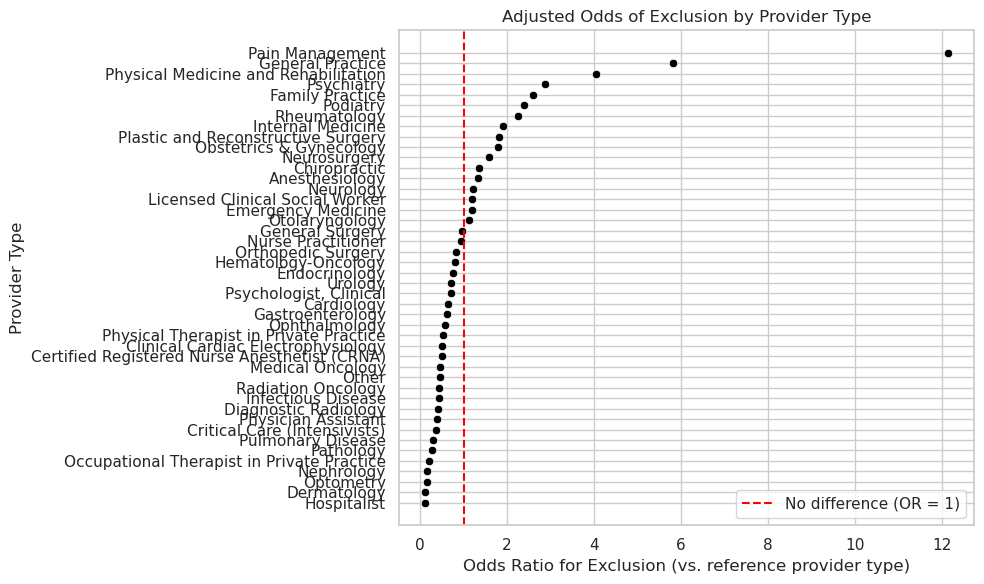

In [165]:
# drop the intercept
or_series = odds_ratios.drop('Intercept')

# build a DataFrame
or_df = (
    or_series
    .reset_index()
    .rename(columns={'index': 'term', 0: 'or'})
)

# extract provider type name
or_df['provider_type'] = (
    or_df['term']
    .str.replace('C(prov_type_collapsed)[T.', '', regex=False)
    .str.rstrip(']')
)

or_df = or_df.sort_values('or', ascending=False)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=or_df,
    x='or',
    y='provider_type',
    color='black'
)

plt.axvline(1.0, color='red', linestyle='--', label='No difference (OR = 1)')
plt.xlabel('Odds Ratio for Exclusion (vs. reference provider type)')
plt.ylabel('Provider Type')
plt.title('Adjusted Odds of Exclusion by Provider Type')
plt.legend()
plt.tight_layout()
plt.show()

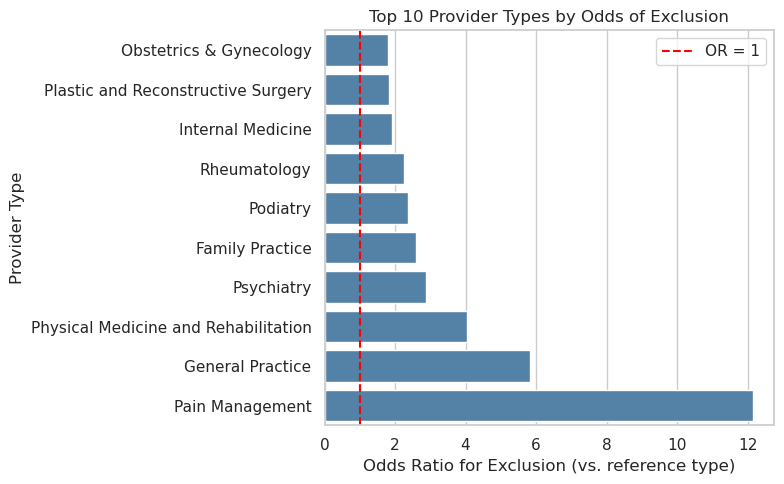

In [166]:
# Drop intercept and build DataFrame
or_series = odds_ratios.drop('Intercept')

or_df = (
    or_series.reset_index()
             .rename(columns={'index': 'term', 0: 'or'})
)

# Extract provider type names 
or_df['provider_type'] = (
    or_df['term']
    .str.replace('C(prov_type_collapsed)[T.', '', regex=False)
    .str.rstrip(']')
)

# Keep top 10 by odds ratio
top10 = or_df.sort_values('or', ascending=False).head(10)


max_len = 40
top10['label'] = top10['provider_type'].str.slice(0, max_len)

# horizontal bar chart, largest at top
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top10.sort_values('or', ascending=True),  # ascending so highest at top
    x='or',
    y='label',
    color='steelblue'
)

plt.axvline(1.0, color='red', linestyle='--', label='OR = 1')
plt.xlabel('Odds Ratio for Exclusion (vs. reference type)')
plt.ylabel('Provider Type')
plt.title('Top 10 Provider Types by Odds of Exclusion')
plt.legend()
plt.tight_layout()
plt.show()

In [167]:
model_df = df[[
    'excluded',                  # 0/1 target
    'Rndrng_Prvdr_Type',         # provider type
    'Rndrng_Prvdr_State_Abrvtn', # state
    'Tot_Mdcr_Pymt_Amt'          # funding
]].dropna()

# Make sure excluded is numeric 0/1
model_df['excluded'] = model_df['excluded'].astype(int)

# Log-transform funding
model_df['log_funding'] = np.log1p(model_df['Tot_Mdcr_Pymt_Amt'])

# Collapse rare provider types
type_counts = model_df['Rndrng_Prvdr_Type'].value_counts()
rare_types = type_counts[type_counts < 50].index
model_df['Rndrng_Prvdr_Type_simplified'] = model_df['Rndrng_Prvdr_Type'].where(
    ~model_df['Rndrng_Prvdr_Type'].isin(rare_types),
    other='Other'
)

# Collapse rare states
state_counts = model_df['Rndrng_Prvdr_State_Abrvtn'].value_counts()
rare_states = state_counts[state_counts < 50].index
model_df['Rndrng_Prvdr_State_simplified'] = model_df['Rndrng_Prvdr_State_Abrvtn'].where(
    ~model_df['Rndrng_Prvdr_State_Abrvtn'].isin(rare_states),
    other='Other'
)

In [168]:
y = model_df['excluded'].astype(float)

X = model_df[[
    'Rndrng_Prvdr_Type_simplified',
    'Rndrng_Prvdr_State_simplified',
    'log_funding'
]]

# One‑hot encode categoricals and ensure float dummies
X = pd.get_dummies(
    X,
    columns=['Rndrng_Prvdr_Type_simplified', 'Rndrng_Prvdr_State_simplified'],
    drop_first=True,
    dtype=float          # this avoids bool columns
)

# Drop zero‑variance columns
X = X.loc[:, X.nunique() > 1]

# Add intercept and ensure float
X = sm.add_constant(X).astype(float)

print(X.dtypes.head())   # should now show all float64

logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

const                                                      float64
log_funding                                                float64
Rndrng_Prvdr_Type_simplified_Ambulatory Surgical Center    float64
Rndrng_Prvdr_Type_simplified_Anesthesiology                float64
Rndrng_Prvdr_Type_simplified_Audiologist                   float64
dtype: object
         Current function value: 0.225812
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               excluded   No. Observations:                12496
Model:                          Logit   Df Residuals:                    12411
Method:                           MLE   Df Model:                           84
Date:                Wed, 17 Dec 2025   Pseudo R-squ.:                  0.1041
Time:                        21:35:24   Log-Likelihood:                -2821.7
converged:                      False   LL-Null:                       -3149.5
Covariance Type:            nonr

/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


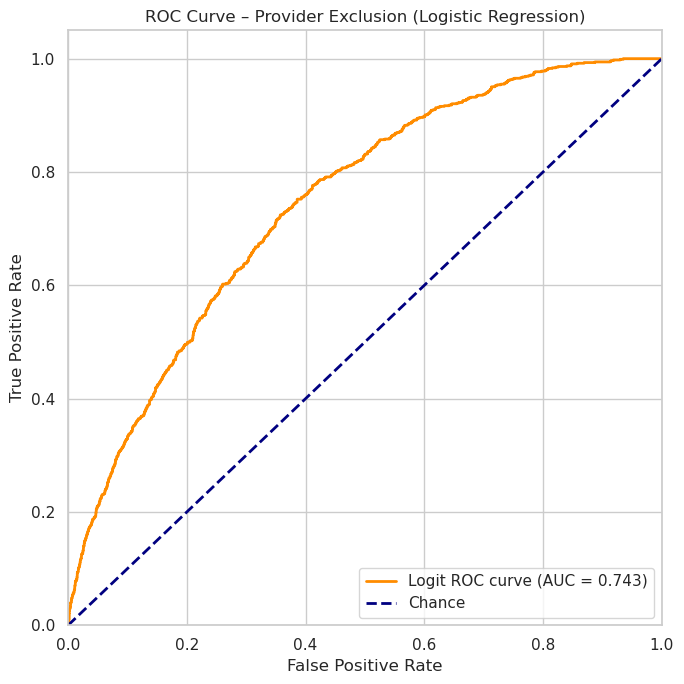

In [169]:
from sklearn.metrics import roc_curve, auc

y_score = logit_model.predict(X)

fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Logit ROC curve (AUC = {roc_auc:0.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Provider Exclusion (Logistic Regression)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()